# **Anomaly detection in time series data**

## **Anomaly -**

Observation that deviates from normal behavior of dataset. \



In [ ]:
from google.colab import files
uploaded = files.upload()

In [2]:
import pandas as pd
#https://pandas.pydata.org/docs/reference/index.html
 
import numpy as np
#https://numpy.org/doc/stable/user/tutorials_index.html
 
from matplotlib import pyplot as plt
import matplotlib.font_manager
#https://matplotlib.org/tutorials/index.html
 
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from sklearn import svm
#https://scikit-learn.org/stable/user_guide.html

# Read Data 

In [3]:
df = pd.read_csv("ambient_temperature_system_failure.txt")

**#Understand data**


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  7267 non-null   object 
 1   value      7267 non-null   float64
dtypes: float64(1), object(1)
memory usage: 113.7+ KB
None


**# First 10 rows of data.**

In [5]:
print(df.head(10))

             timestamp      value
0  2013-07-04 00:00:00  69.880835
1  2013-07-04 01:00:00  71.220227
2  2013-07-04 02:00:00  70.877805
3  2013-07-04 03:00:00  68.959400
4  2013-07-04 04:00:00  69.283551
5  2013-07-04 05:00:00  70.060966
6  2013-07-04 06:00:00  69.279765
7  2013-07-04 07:00:00  69.369608
8  2013-07-04 08:00:00  69.166714
9  2013-07-04 09:00:00  68.986083


 - Change the type of timestamp
 - Convert the temperature value (Fahrenheit to Celsius) 

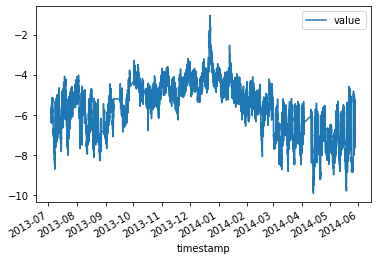

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['value'] = (df['value'] - 32) * 5/9
df.plot(x='timestamp', y='value')

# Extract useful features

Extracting the following useful features :

**1. Hours** - 24 hours (0-23) \

**2. Daytime** - \
 Daytime = 1 , if hour is in 7:00 AM to 10:00 PM \
 Daytime = 0 , otherwise (Night_time) \

**3. DayOfTheWeek** -  ( Monday - 0 )  to (Sunday - 6) \

**4. WeekDay** - \
WeekDay = 1 , if Day of week < 5 \
WeekDay = 0 , Otherwise (saturday and sunday)

**5. categories** - \
0 - Week end night \
1 - Week end daytime \
2 - Week day night \
3 - Week day day time \

                                   



In [8]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)

In [9]:
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)

In [10]:
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

In [11]:
df['categories'] = df['WeekDay']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']


# **Anomaly detection using OneClass SVM**



**Support Vector Machine** 

**1. OneClass SVM(Support vector machine)**


- SVM use a hyperplane to separates the two classes with max margin.

- One class SVM Unsupervised Outlier Detection method

- One Class SVM is used for anomaly detection. The idea of anomaly detection is to detect the events that happen rarely.

- One class SVM finds a hyperball in higher dimensional space, that contains only normal points.

**Example :**

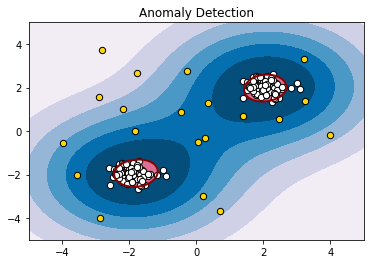

In [13]:
outliers_fraction = 0.01
data = df[['value', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)    # Standardize features by removing the mean and scaling to unit variance
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction)
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
df['anomaly'] = pd.Series(model.predict(data))
df['anomaly'] = df['anomaly'].map( {1: 0, -1: 1} )
print(df['anomaly'].value_counts())

0    7198
1      69
Name: anomaly, dtype: int64


**visualize anomaly**

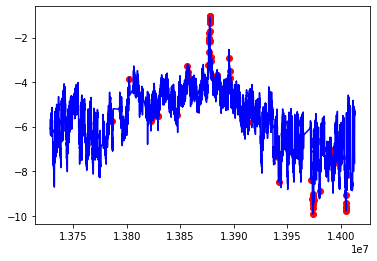

In [14]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly'] == 1, ['time_epoch', 'value']] #anomaly

ax.plot(df['time_epoch'], df['value'], color='blue')
ax.scatter(a['time_epoch'],a['value'], color='red')
plt.show()

In [15]:
df.to_csv('data1.csv', index=False)